In [51]:
import numpy as np
import torch 
import scipy.stats
import math
from scipy.stats import multivariate_normal
from torch import distributions
from matplotlib.pylab import plt
import pymc3 as pm
import random
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve, auc
from sklearn import svm

In [2]:
#pip install pymc3
#pip install numpy --upgrade
OMP_NUM_THREADS=20
openmp=True

# Model 1
$\ Z_{it}|Z_{i,t-1}$ ~ $\ N$($\Omega Z_{i,t-1}$, $\ I$\)\
$\ X_{it}|Z_{i,t}$ ~ $\ N$($\ Z_{i,t}$, $\ I$\)

Theoretical derivation gives:\
$\ Z_{it}|X_{i,t}$ ~ $\ N$($(1/2)*(\Omega Z_{i,t-1} + \ X_{i,t})$, $\ I/2$\)


In [3]:
N = 50 # num patients
T = 10 # num of hospital visits for each patients
random.seed(53)
zdim = 10
xdim = zdim

Z = torch.zeros((N, T, zdim)) # latent
logPZ = torch.zeros((N, T)) 
X = torch.zeros((N, T, xdim)) # observed
PX = torch.zeros((N, T, xdim)) 
logPX = torch.zeros((N, T))
d = torch.ones(zdim,requires_grad = True) 
omega = torch.diag(d) # should be invertible
Psi = torch.ones((xdim,zdim),requires_grad = True) # should be full rank , xdim > zdim


for t in range(1,T):
    # Zit|Zi,t-1
    meanz = torch.matmul(Z[:,t-1], omega)
    cov = torch.eye(zdim)
    Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov)
    Z[:,t] = Zt.sample()
    logPZ[:,t] = Zt.log_prob(Z[:,t])


    #Xit|Zit
    meanx = Z[:,t] 
    cov = torch.eye(xdim) 
    Xt = torch.distributions.multivariate_normal.MultivariateNormal(meanx, cov)
    X[:,t] = Xt.sample()
    logPX[:,t] = Xt.log_prob(X[:,t])


        
        
def posterior_i(x,omega):
    n,t,xdim = x.size()
    zdim = xdim
    z = torch.zeros((n,t,zdim))
    logpz = torch.zeros((n, t)) 

    for j in range(1,t):     
        mean = 1/2*(torch.matmul(Z[:,j-1], omega) + x[:,j])
        cov = torch.eye(zdim)*(1/2)
        zt = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
        z[:,j] = zt.sample()
        logpz[:,j] = zt.log_prob(z[:,j])     
    return z, logpz
        

    
Z_posterior = torch.zeros((N, T, zdim))
Z_posterior,log_posterior = posterior_i(X,omega)

In [4]:
torch.mean((Z-Z_posterior)**2)

tensor(0.8829)

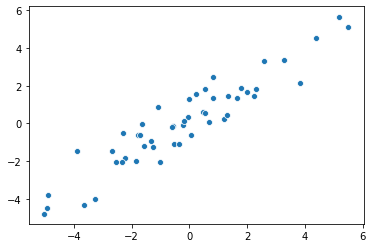

In [5]:
sns.scatterplot(Z_posterior[:,T-1,0],Z[:,T-1,0])

# Model 2

$\ Z_{it}|Z_{i,t-1}$ ~ $\ N$($\Omega Z_{i,t-1}$,$\ I$\)\
$\ X_{it}|Z_{i,t}$ ~ $\ N$($\Psi Z_{i,t}$,$\ I$\)

Theoretical derivation gives:\
$\ Z_{it}|X_{i,t}$ ~ $\ N$($(I + \Psi^T \Psi)^{-1}*(\Omega Z_{i,t-1} + \Psi^{T} X_{i,t})$, $(I + \Psi^T \Psi)^{-1}\$)


### Testing cases

In [6]:
def posterior_i2(x,omega,psi,zdim,cov_scale):
    n,t,xdim = x.size()
    z = torch.zeros((n,t,zdim))
    logpz = torch.zeros((n, t)) 
    I_psi = torch.eye(zdim) + (1/cov_scale) * torch.matmul(psi.t(),psi)
    inverse = I_psi.inverse()
 
    for j in range(1,t):     
#        print(z[:,j-1].size(), omega.size())
#        print(x[:,j].size(), psi.t().size())

        mean2 = torch.matmul(z[:,j-1], omega) + (1/cov_scale) * torch.matmul(x[:,j],psi)
        mean = torch.matmul(mean2,inverse)
        zt = torch.distributions.multivariate_normal.MultivariateNormal(mean, inverse)
        z[:,j] = zt.sample()
        logpz[:,j] = zt.log_prob(z[:,j])     
    return z, logpz
        

In [39]:
def testing_psi1(N,T,zdim,xdim,cov_scale):
    Z = torch.zeros((N, T, zdim)) # latent
    logPZ = torch.zeros((N, T)) 
    X = torch.zeros((N, T, xdim)) # observed
    PX = torch.zeros((N, T, xdim)) 
    logPX = torch.zeros((N, T))
    d = torch.ones(zdim,requires_grad = True) 
    omega = torch.diag(d) # should be invertible
    Psi = torch.ones((xdim,zdim),requires_grad = True) # should be full rank , xdim > zdim


    for t in range(1,T):
        # Zit|Zi,t-1
        meanz = torch.matmul(Z[:,t-1], omega)
        cov = torch.eye(zdim)
        Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov)
        Z[:,t] = Zt.sample()
        logPZ[:,t] = Zt.log_prob(Z[:,t])


        #Xit|Zit
        meanx = torch.matmul(Z[:,t], Psi.t())
        cov = torch.eye(xdim)*cov_scale
        Xt = torch.distributions.multivariate_normal.MultivariateNormal(meanx, cov)
        X[:,t] = Xt.sample()
        logPX[:,t] = Xt.log_prob(X[:,t])


    Z_posterior = torch.zeros((N, T, zdim))
    Z_posterior,log_posterior = posterior_i2(X,omega,Psi,zdim, cov_scale)
    return Z, X, Z_posterior, log_posterior

### 1. T = 1, xdim = zdim = 1, Psi = 1, cov(X|Z) = I*(1e-3)

$\ X_{it}|Z_{i,t}$ ~ $\ N$($\Psi Z_{i,t}$,$\ I*(1e-3)$\)

Theoretical derivation gives:\
$\ Z_{it}|X_{i,t}$ ~ $\ N$($(I + (1e+3) *\Psi^T \Psi)^{-1}*(\Omega Z_{i,t-1} + (1e+3) *\Psi^{T} X_{i,t})$, $(I + (1e+3) * \Psi^T \Psi)^{-1}\$)


Text(0.5, 0, 'simulated z')

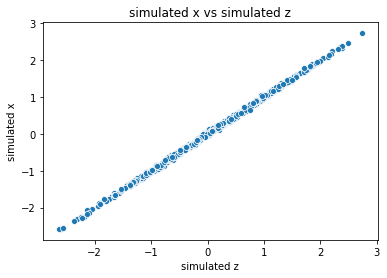

In [8]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = 1

random.seed(53)
Z1,X1, Z_posterior1, log_posterior1 = testing_psi1(N,T,zdim,xdim,1e-3)
test1_1 = sns.scatterplot(Z1[:,T-1,0],X1[:,T-1,0])
test1_1.set_title('simulated x vs simulated z')
test1_1.set_ylabel('simulated x')
test1_1.set_xlabel('simulated z')

Text(0.5, 0, 'posterior z')

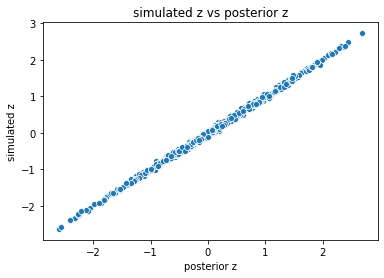

In [9]:
test1_2 = sns.scatterplot(Z_posterior1[:,T-1,0],Z1[:,T-1,0])
test1_2.set_title('simulated z vs posterior z')
test1_2.set_ylabel('simulated z')
test1_2.set_xlabel('posterior z')

Text(0.5, 0, 'posterior z')

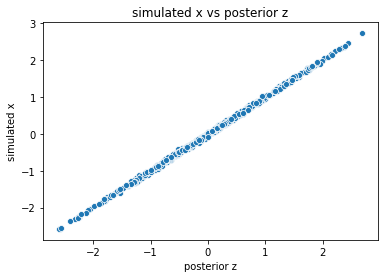

In [10]:
test1_3 = sns.scatterplot(Z_posterior1[:,T-1,0],X1[:,T-1,0])
test1_3.set_title('simulated x vs posterior z')
test1_3.set_ylabel('simulated x')
test1_3.set_xlabel('posterior z')

### 2. T = 1, xdim = zdim = 1, Psi = 1, cov(X|Z) = I*(1e+4)

$\ X_{it}|Z_{i,t}$ ~ $\ N$($\Psi Z_{i,t}$,$\ I*(1e+4)$\)

Theoretical derivation gives:\
$\ Z_{it}|X_{i,t}$ ~ $\ N$($(I + (1e-4) *\Psi^T \Psi)^{-1}*(\Omega Z_{i,t-1} + (1e-4) *\Psi^{T} X_{i,t})$, $(I + (1e-4) * \Psi^T \Psi)^{-1}\$)


Text(0.5, 0, 'simulated z')

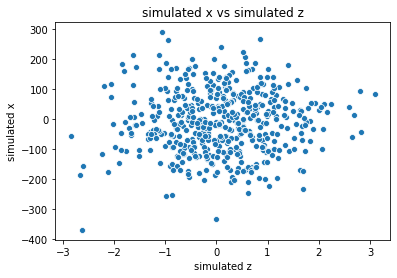

In [11]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = 1
random.seed(53)
Z2,X2, Z_posterior2, log_posterior2 = testing_psi1(N,T,zdim,xdim,1e+4)
test2_1 = sns.scatterplot(Z2[:,T-1,0],X2[:,T-1,0])
test2_1.set_title('simulated x vs simulated z')
test2_1.set_ylabel('simulated x')
test2_1.set_xlabel('simulated z')

Text(0.5, 0, 'posterior z')

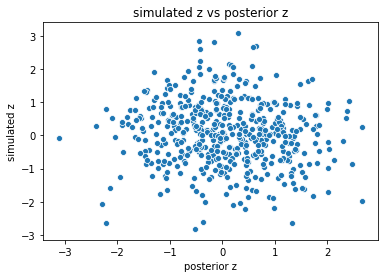

In [12]:
test2_2 = sns.scatterplot(Z_posterior2[:,T-1,0],Z2[:,T-1,0])
test2_2.set_title('simulated z vs posterior z')
test2_2.set_ylabel('simulated z')
test2_2.set_xlabel('posterior z')

Text(0.5, 0, 'posterior z')

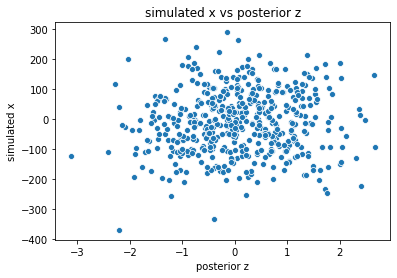

In [13]:
test2_3 = sns.scatterplot(Z_posterior2[:,T-1,0],X2[:,T-1,0])
test2_3.set_title('simulated x vs posterior z')
test2_3.set_ylabel('simulated x')
test2_3.set_xlabel('posterior z')

### 3. xdim = 1000  zdim = 2, Psi = 1, cov(X|Z) = I


Text(0.5, 0, 'simulated z')

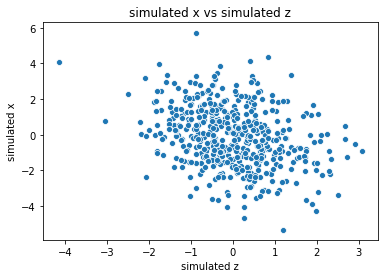

In [36]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 2
xdim = 1000
random.seed(53)
Z3,X3, Z_posterior3, log_posterior3 = testing_psi1(N,T,zdim,xdim,1)
test3_1 = sns.scatterplot(Z3[:,T-1,1],X3[:,T-1,1])
test3_1.set_title('simulated x vs simulated z')
test3_1.set_ylabel('simulated x')
test3_1.set_xlabel('simulated z')

Text(0.5, 0, 'posterior z')

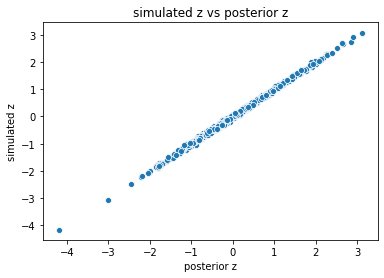

In [37]:
test3_2 = sns.scatterplot(Z_posterior3[:,T-1,1],Z3[:,T-1,1])
test3_2.set_title('simulated z vs posterior z')
test3_2.set_ylabel('simulated z')
test3_2.set_xlabel('posterior z')

Text(0.5, 0, 'posterior z')

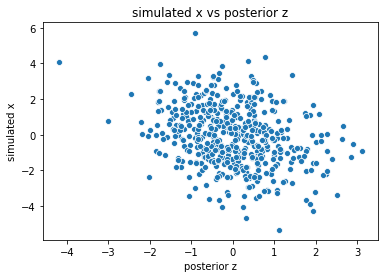

In [38]:
test3_3 = sns.scatterplot(Z_posterior3[:,T-1,1],X3[:,T-1,1])
test3_3.set_title('simulated x vs posterior z')
test3_3.set_ylabel('simulated x')
test3_3.set_xlabel('posterior z')

### 4. xdim = 1  zdim = 1, Psi = 1, cov(X|Z) = I


Text(0.5, 0, 'simulated z')

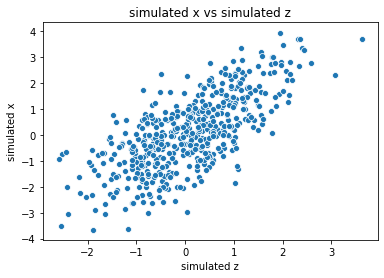

In [40]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = 1
random.seed(53)
Z4,X4, Z_posterior4, log_posterior4 = testing_psi1(N,T,zdim,xdim,1)
test4_1 = sns.scatterplot(Z4[:,T-1,0],X4[:,T-1,0])
test4_1.set_title('simulated x vs simulated z')
test4_1.set_ylabel('simulated x')
test4_1.set_xlabel('simulated z')

Text(0.5, 0, 'posterior z')

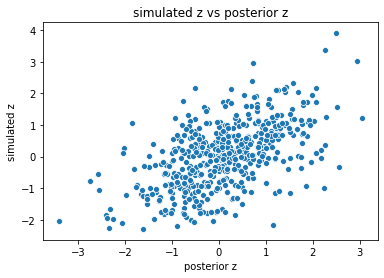

In [18]:
test4_2 = sns.scatterplot(Z_posterior4[:,T-1,0],Z4[:,T-1,0])
test4_2.set_title('simulated z vs posterior z')
test4_2.set_ylabel('simulated z')
test4_2.set_xlabel('posterior z')

Text(0.5, 0, 'posterior z')

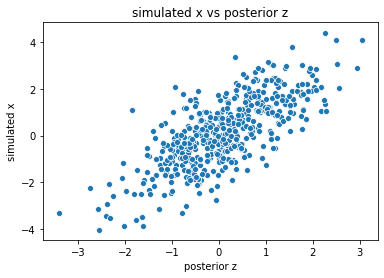

In [19]:
test4_3 = sns.scatterplot(Z_posterior4[:,T-1,0],X4[:,T-1,0])
test4_3.set_title('simulated x vs posterior z')
test4_3.set_ylabel('simulated x')
test4_3.set_xlabel('posterior z')

### 5. xdim = 1 zdim = 1, Psi = 0, cov(X|Z) = I


In [20]:
def testing_psi0(N,T,zdim,xdim, cov_scale):
    Z = torch.zeros((N, T, zdim)) # latent
    logPZ = torch.zeros((N, T)) 
    X = torch.zeros((N, T, xdim)) # observed
    PX = torch.zeros((N, T, xdim)) 
    logPX = torch.zeros((N, T))
    d = torch.ones(zdim,requires_grad = True) 
    omega = torch.diag(d) # should be invertible
    Psi = torch.zeros((xdim,zdim),requires_grad = True) # should be full rank , xdim > zdim


    for t in range(1,T):
        # Zit|Zi,t-1
        meanz = torch.matmul(Z[:,t-1], omega)
        cov = torch.eye(zdim)
        Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov)
        Z[:,t] = Zt.sample()
        logPZ[:,t] = Zt.log_prob(Z[:,t])


        #Xit|Zit
        meanx = torch.matmul(Z[:,t], Psi.t())
        cov = torch.eye(xdim)*cov_scale
        Xt = torch.distributions.multivariate_normal.MultivariateNormal(meanx, cov)
        X[:,t] = Xt.sample()
        logPX[:,t] = Xt.log_prob(X[:,t])


    Z_posterior = torch.zeros((N, T, zdim))
    Z_posterior,log_posterior = posterior_i2(X,omega,Psi,zdim, cov_scale)
    return Z, X, Z_posterior, log_posterior

Text(0.5, 0, 'simulated z')

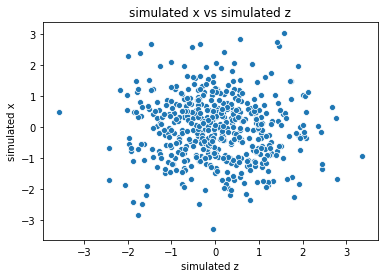

In [21]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = 1
random.seed(53)
Z5,X5, Z_posterior5, log_posterior5 = testing_psi0(N,T,zdim,xdim,1)
test5_1 = sns.scatterplot(Z5[:,T-1,0],X5[:,T-1,0])
test5_1.set_title('simulated x vs simulated z')
test5_1.set_ylabel('simulated x')
test5_1.set_xlabel('simulated z')

Text(0.5, 0, 'posterior z')

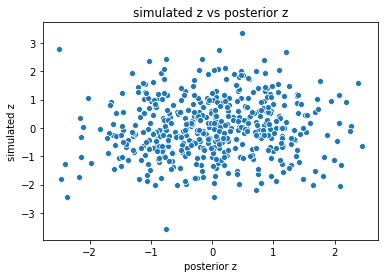

In [22]:
test5_2 = sns.scatterplot(Z_posterior5[:,T-1,0],Z5[:,T-1,0])
test5_2.set_title('simulated z vs posterior z')
test5_2.set_ylabel('simulated z')
test5_2.set_xlabel('posterior z')

Text(0.5, 0, 'posterior z')

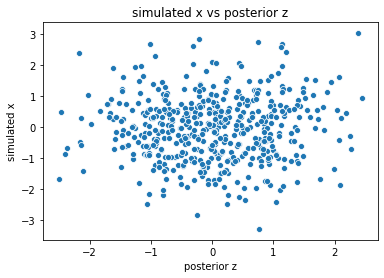

In [23]:
test5_3 = sns.scatterplot(Z_posterior5[:,T-1,0],X5[:,T-1,0])
test5_3.set_title('simulated x vs posterior z')
test5_3.set_ylabel('simulated x')
test5_3.set_xlabel('posterior z')

# Model 3

$\ Z_{it}|Z_{i,t-1}$ ~ $\ N$($\Omega Z_{i,t-1}$,$\ I$\)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))

Theoretical derivation gives:\
$\ Z_{it}|X_{i,t}$ ~ $\ N$($(\Omega Z_{i,t-1} + \Psi^{T} e_{X_{i,t}}^{T})$, $I$)

A Gaussian mixture model with two means.


In [23]:
def posterior_categorical(x,omega,psi,zdim,cov_scale):
    n,t,xdim = x.size()
    z = torch.zeros((n,t,zdim))
    logpz = torch.zeros((n, t)) 
    e = torch.zeros((n,t,xdim))
    for i in range(n):
        for k in range(1,t):
            e[i,k,int(x[i,k,0])] = 1 

    
    for j in range(1,t):     
#        print(z[:,j-1].size(), omega.size())
#        print(x[:,j].size(), psi.t().size())

        mean = torch.matmul(z[:,j-1], omega) + torch.matmul(e[:,j],psi) ## change to index of psi
        cov = torch.eye(zdim) 
        zt = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
        z[:,j] = zt.sample()
        logpz[:,j] = zt.log_prob(z[:,j])     
    return z, logpz
        

In [75]:
def testing_categorical(N,T,zdim,xdim,cov_scale):
    Z = torch.zeros((N, T, zdim)) # latent
    logPZ = torch.zeros((N, T)) 
    X = torch.zeros((N, T, xdim)) # observed
    PX = torch.zeros((N, T, xdim)) 
    logPX = torch.zeros((N, T, xdim))
    d = torch.ones(zdim,requires_grad = True) 
    omega = torch.diag(d) # should be invertible
    Psi = torch.arange(0,xdim*0.01,0.01).reshape(xdim,zdim) # should be full rank , xdim > zdim
                         


    for t in range(1,T):
        # Zit|Zi,t-1
        meanz = torch.matmul(Z[:,t-1], omega)
        cov = torch.eye(zdim)
        Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov)
        Z[:,t] = Zt.sample()
        logPZ[:,t] = Zt.log_prob(Z[:,t])


        #Xit|Zit
        Psi_z = torch.matmul(Z[:,t], Psi.t()) 
        logPX[:,t] = Psi_z - torch.logsumexp(Psi_z,0,keepdim=True)
        PX[:,t] = torch.exp(logPX[:,t])
        
        for i in range(N):
            Xt = torch.distributions.categorical.Categorical(PX[i,t])
            X[i,t] = Xt.sample()
    
    Z_posterior = torch.zeros((N, T, zdim))
    Z_posterior,log_posterior = posterior_categorical(X,omega,Psi,zdim, cov_scale)
    return Z, X, Z_posterior, log_posterior

### Testing 1

xdim = 1000\
zdim = 2\
Expect perfect line

tensor([167., 112.,  38., 446., 162., 153., 173.,  39., 312., 159.,  24., 227.,
         33.,  63.,  83.,  92.,  26.,  35.,   2.,  88.,  77.,  80., 137.,  64.,
         43.,   5.,  15.,  75., 349.,  64.,  69.,   4., 128.,  54., 105., 110.,
         41.,  84.,  69.,  28., 112.,  66.,  38.,  71.,  23.,   3., 178.,  94.,
        151., 418., 519.,  10.,  45.,  86., 288.,  10.,  73.,  17., 227.,  37.,
        181., 222.,  51.,  98.,  47.,  80.,  18.,  34.,  58.,  69.,  18.,  37.,
         18., 275., 136.,  65.,  32.,  18., 376.,  51.,  38., 936., 129., 128.,
         82.,  39.,  34., 659., 133., 120., 239.,  54.,  68.,  81.,  51.,  27.,
          2.,  91.,  76., 127., 260.,  34.,  32., 182.,  96.,  56., 117.,  47.,
         55., 340., 104.,  22., 132., 182., 150.,  32., 263., 144.,  45.,   2.,
        384.,  93.,  14.,  64.,  34., 212., 226.,  33., 105., 159.,  48.,  79.,
         32.,  99., 101.,  30., 246.,  17.,  54.,  57.,  82.,  22.,  48., 114.,
        334., 144.,  35., 202.,   1.,  7

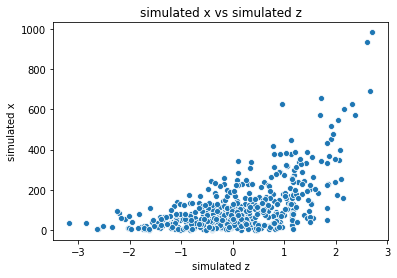

In [76]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = 1000

random.seed(53)
Z1,X1, Z_posterior1, log_posterior1 = testing_categorical(N,T,zdim,xdim,1e-3)
test1_1 = sns.scatterplot(Z1[:,T-1,0],X1[:,T-1,0])
test1_1.set_title('simulated x vs simulated z')
test1_1.set_ylabel('simulated x')
test1_1.set_xlabel('simulated z')
print(X1[:,T-1,0])

Text(0.5, 0, 'posterior z')

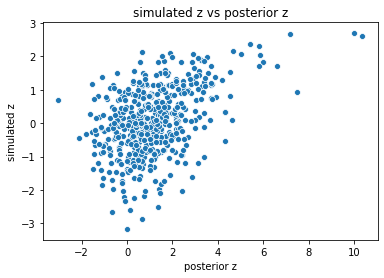

In [78]:
test1_2 = sns.scatterplot(Z_posterior1[:,T-1,0],Z1[:,T-1,0])
test1_2.set_title('simulated z vs posterior z')
test1_2.set_ylabel('simulated z')
test1_2.set_xlabel('posterior z')

Text(0.5, 0, 'posterior z')

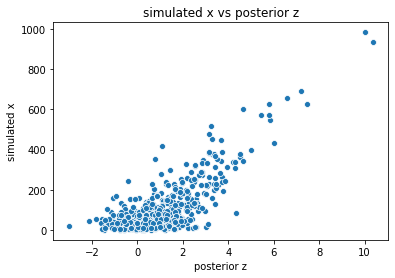

In [77]:
test1_3 = sns.scatterplot(Z_posterior1[:,T-1,0],X1[:,T-1,0])
test1_3.set_title('simulated x vs posterior z')
test1_3.set_ylabel('simulated x')
test1_3.set_xlabel('posterior z')

### Testing 2

xdim = 1 zdim = 1\
Expect weak relationship

Text(0.5, 0, 'simulated z')

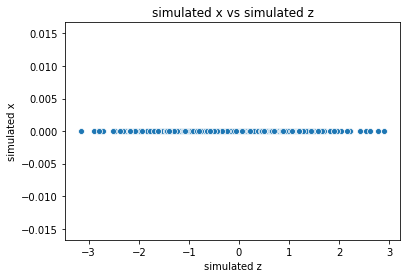

In [50]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 1
xdim = 1
random.seed(53)
Z2,X2, Z_posterior2, log_posterior2 = testing_categorical(N,T,zdim,xdim,1)
test2_1 = sns.scatterplot(Z2[:,T-1,0],X2[:,T-1,0])
test2_1.set_title('simulated x vs simulated z')
test2_1.set_ylabel('simulated x')
test2_1.set_xlabel('simulated z')

Text(0.5, 0, 'posterior z')

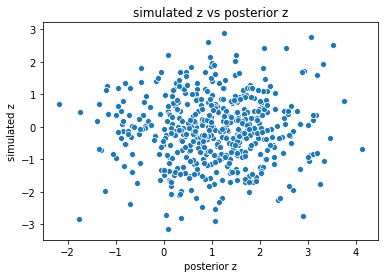

In [51]:
test2_2 = sns.scatterplot(Z_posterior2[:,T-1,0],Z2[:,T-1,0])
test2_2.set_title('simulated z vs posterior z')
test2_2.set_ylabel('simulated z')
test2_2.set_xlabel('posterior z')

Text(0.5, 0, 'posterior z')

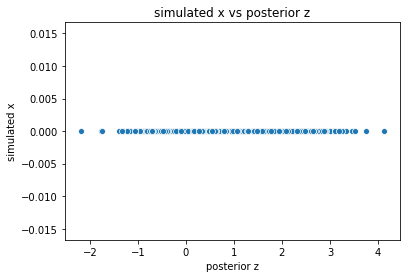

In [52]:
test2_3 = sns.scatterplot(Z_posterior2[:,T-1,0],X2[:,T-1,0])
test2_3.set_title('simulated x vs posterior z')
test2_3.set_ylabel('simulated x')
test2_3.set_xlabel('posterior z')

### Testing 3

Psi = 0\
xdim = 1000\
zdim = 2\
Expect no relationship

In [54]:
def testing_categorical_psi0(N,T,zdim,xdim,cov_scale):
    Z = torch.zeros((N, T, zdim)) # latent
    logPZ = torch.zeros((N, T)) 
    X = torch.zeros((N, T, xdim)) # observed
    PX = torch.zeros((N, T, xdim)) 
    logPX = torch.zeros((N, T, xdim))
    d = torch.ones(zdim,requires_grad = True) 
    omega = torch.diag(d) # should be invertible
    Psi = torch.zeros((xdim,zdim),requires_grad = True) # should be full rank , xdim > zdim


    for t in range(1,T):
        # Zit|Zi,t-1
        meanz = torch.matmul(Z[:,t-1], omega)
        cov = torch.eye(zdim)
        Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov)
        Z[:,t] = Zt.sample()
        logPZ[:,t] = Zt.log_prob(Z[:,t])


        #Xit|Zit
        Psi_z = torch.matmul(Z[:,t], Psi.t()) 
        logPX[:,t] = Psi_z - torch.logsumexp(Psi_z,0,keepdim=True)
        PX[:,t] = torch.exp(logPX[:,t])
        
        for i in range(N):
            Xt = torch.distributions.categorical.Categorical(PX[i,t])
            X[i,t] = Xt.sample()

    Z_posterior = torch.zeros((N, T, zdim))
    Z_posterior,log_posterior = posterior_categorical(X,omega,Psi,zdim, cov_scale)
    return Z, X, Z_posterior, log_posterior

Text(0.5, 0, 'simulated z')

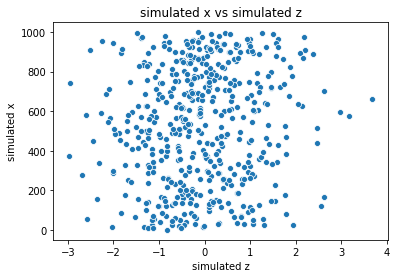

In [55]:
N = 500 # num patients
T = 2 # num of hospital visits for each patients
zdim = 2
xdim = 1000

random.seed(53)
Z3,X3, Z_posterior3, log_posterior3 = testing_categorical_psi0(N,T,zdim,xdim,1e-3)
test3_1 = sns.scatterplot(Z3[:,T-1,1],X3[:,T-1,1])
test3_1.set_title('simulated x vs simulated z')
test3_1.set_ylabel('simulated x')
test3_1.set_xlabel('simulated z')

Text(0.5, 0, 'posterior z')

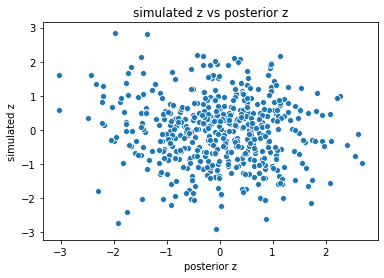

In [56]:
test3_2 = sns.scatterplot(Z_posterior3[:,T-1,0],Z3[:,T-1,0])
test3_2.set_title('simulated z vs posterior z')
test3_2.set_ylabel('simulated z')
test3_2.set_xlabel('posterior z')

Text(0.5, 0, 'posterior z')

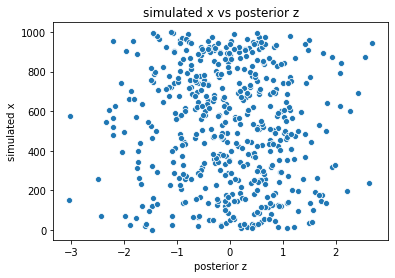

In [57]:
test3_3 = sns.scatterplot(Z_posterior3[:,T-1,0],X3[:,T-1,0])
test3_3.set_title('simulated x vs posterior z')
test3_3.set_ylabel('simulated x')
test3_3.set_xlabel('posterior z')

In [52]:
def posterior_categorical(x,y,psi,zdim):
    n,t,xdim = x.size()
    z = torch.zeros((n,t,zdim))
    logpz = torch.zeros((n, t)) 
    e = torch.zeros((n,t,xdim))
    for i in range(n):
        for k in range(1,t):
            e[i,k,int(x[i,k,0])] = 1 

    for i in range(n):
        for j in range(1,t):    
            mean = 0.9*z[i,j-1] + 1.5**y[i]*torch.matmul(e[i,j],psi) ## change to index of psi
            cov = 1.5**y[i] 
            zt = torch.distributions.normal.Normal(mean, cov)
            z[i,j] = zt.sample()
            logpz[i,j] = zt.log_prob(z[i,j])     
    return z, logpz
        

# Model 4

$\ Y_i $ ~ $Bernoulli(1/5)$\
$\ Z_{it}|Z_{i,t-1}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}$,$5.1^{Y_i}$)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))\


Models               | P = 0.2 | P = 0.5 |\
Logistic Regression: Accuracy | 0.925 | 0.9275| \
Numerical Integresion: $P(y = 1 |\vec{x})$ | 0. 892 | 0.69 |

In [218]:
def ROC(y_test, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [221]:
zdim = 1
xdim = 1000
N = 1000 # patients
T = 10 # time steps

# first time step entry should be from gaussian(0, 5.1**yi)

Z = torch.zeros((N, T, zdim)) # latent
logPZ = torch.zeros((N, T)) 
X = torch.zeros((N, T, xdim)) # observed
PX = torch.zeros((N, T, xdim)) 
logPX = torch.zeros((N, T, xdim))
Psi = torch.arange(0,xdim*0.01,0.01).reshape(xdim,zdim) # should be full rank , xdim > zdim
Y = torch.zeros(N)


Y = torch.distributions.Bernoulli(.2).sample((N,))
cov_diag = torch.pow(5.1, Y)
cov = torch.diag(cov_diag)

# t = 0
mean = torch.zeros((N,))
Zt = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
Z[:,0] = Zt.sample().unsqueeze(1)
logPZ[:,0] = Zt.log_prob(Z[:,t].squeeze(1))

Psi_z = torch.matmul(Z[:,0], Psi.t())
PX[:,0] = torch.nn.functional.softmax(Psi_z, dim = 1)
Xt = torch.distributions.categorical.Categorical(PX[:,0])
Xit = Xt.sample()
X[:,0] = torch.nn.functional.one_hot(Xit)


for t in range(1,T):
    # Zit|Zi,t-1, Yi
    meanz = (0.9*Z[:,t-1]).squeeze(1)
    Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov)
    Z[:,t] = Zt.sample().unsqueeze(1)
    logPZ[:,t] = Zt.log_prob(Z[:,t].squeeze(1))

    #Xit|Zit
    Psi_z = torch.matmul(Z[:,t], Psi.t())
    PX[:,t] = torch.nn.functional.softmax(Psi_z, dim = 1)
    Xt = torch.distributions.categorical.Categorical(PX[:,t])
    Xit = Xt.sample()
    X[:,t] = torch.nn.functional.one_hot(Xit)


In [222]:
train_idx = torch.randint(0, N, (math.floor(0.8*N),))
X_train = X[train_idx,:,:]
X_test = X[-train_idx,:,:]
xd1, xd2, xd3 = X_train.shape
X_train_lr = X_train.view(xd1, xd2*xd3)
xd1, xd2, xd3 = X_test.shape
X_test_lr = X_test.view(xd1, xd2*xd3)

In [223]:
y_train = Y[train_idx]
y_test = Y[-train_idx]

In [224]:
lr_accuracy = torch.zeros(T)

    
# logistic regression 
# penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
clf = LogisticRegression(solver = 'liblinear',random_state = 0).fit(X_train_lr, y_train)
y_pred_lr = clf.predict(X_test_lr)
y_prob_lr = clf.predict_proba(X_test_lr)[:,1]

lr_accuracy = accuracy_score(y_test,y_pred_lr)

In [225]:
lr_accuracy

0.9025

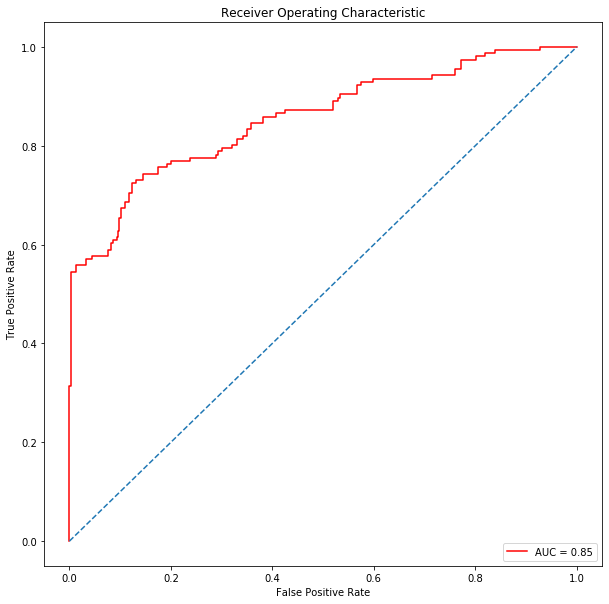

In [226]:
ROC(y_test, y_prob_lr)

## Numerical integration approach

$\ Z_{it}^{(k)}|Z_{i,t-1}^{(k)}, Y_i$ ~ $\ N$($0.9 Z_{i,t-1}^{(k)}$,$5.1^{Y_i}$)\
$\ X_{it}|Z_{i,t}$ ~ $\ Categorical$($\sigma(\Psi Z_{i,t}$))

$P(X|Y = 1) = E_{P(Z|Y = 1)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 1)$\
$P(X|Y = 0) = E_{P(Z|Y = 0)} [P(X|Z)] \approx \frac{1}{K} \sum_{k=1}^{K} P(X|Z^{(k)}),  Z^{(k)} \sim P(Z^{(k)}|Y = 0)$

$P(Y = 1 |X) = \frac{P(X|Y = 1)P(Y=1)}{P(X|Y = 1)P(Y=1) + P(X|Y = 0)P(Y=0)}$

In [302]:
zdim = 1
xdim = 1000
N = 1000 # patients
T = 10 # time steps
K = 100 # simulation times

Z = torch.zeros((K, N, T,zdim)) 
logPZ = torch.zeros((K, N, T,zdim)) 
PX_y1 = torch.zeros((K, N, T)) 
logPX_y1 = torch.zeros((K, N, T))
PX_y0 = torch.zeros((K, N, T)) 
logPX_y0 = torch.zeros((K, N, T))
Psi = torch.arange(0,xdim*0.01,0.01).reshape(xdim,zdim) 


for i in range(N):    
    # intitialize time step 0
    meanz_t0 = torch.zeros((K,))
    cov_y1 = torch.diag(meanz_t0+5.1)
    cov_y0 = torch.diag(meanz_t0+1)  

    ## y = 1
    Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz_t0, cov_y1)
    Z[:,i,0,0] = Zt.sample()
    logPZ[:,i,0,0] = Zt.log_prob(Z[:,i,0,0])

    Psi_z = torch.matmul(Z[:,i,0,], Psi.t())     
    PX  = torch.nn.functional.softmax(Psi_z, dim = 1)
    Xt = torch.distributions.categorical.Categorical(PX)
    Xit = Xt.sample() # index for each row
    j = torch.arange(PX_y1[:,i,0].size(0)).long()
    PX_y1[:,i,0] = PX[j, Xit]
    logPX_y1[:,i,0] = torch.log(PX_y1[:,i,0])
    
    ## y = 0
    Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz_t0, cov_y0)
    Z[:,i,0,0] = Zt.sample()
    logPZ[:,i,0,0] = Zt.log_prob(Z[:,i,0,0])

    Psi_z = torch.matmul(Z[:,i,0,], Psi.t())     
    PX  = torch.nn.functional.softmax(Psi_z, dim = 1)
    Xt = torch.distributions.categorical.Categorical(PX)
    Xit = Xt.sample() # index for each row
    j = torch.arange(PX_y0[:,i,0].size(0)).long()
    PX_y0[:,i,0] = PX[j, Xit]
    logPX_y0[:,i,0] = torch.log(PX_y0[:,i,0])
  
    for t in range(1,T):
        meanz = 0.9*Z[:,i,t-1].squeeze(1)
        Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov_y1)
        Z[:,i,t,0] = Zt.sample()
        logPZ[:,i,t,0] = Zt.log_prob(Z[:,i,t,0])

        Psi_z = torch.matmul(Z[:,i,t,], Psi.t())     
        PX  = torch.nn.functional.softmax(Psi_z, dim = 1)
        Xt = torch.distributions.categorical.Categorical(PX)
        Xit = Xt.sample() # index for each row
        j = torch.arange(PX_y1[:,i,t].size(0)).long()
        PX_y1[:,i,t] = PX[j, Xit]
        logPX_y1[:,i,t] = torch.log(PX_y1[:,i,t])
    
    
        Zt = torch.distributions.multivariate_normal.MultivariateNormal(meanz, cov_y0)
        Z[:,i,t,0] = Zt.sample()
        logPZ[:,i,t,0] = Zt.log_prob(Z[:,i,t,0])

        Psi_z = torch.matmul(Z[:,i,t,], Psi.t())     
        PX  = torch.nn.functional.softmax(Psi_z, dim = 1)
        Xt = torch.distributions.categorical.Categorical(PX)
        Xit = Xt.sample() # index for each row
        j = torch.arange(PX_y0[:,i,t].size(0)).long()
        PX_y0[:,i,t] = PX[j, Xit]
        logPX_y0[:,i,t] = torch.log(PX_y0[:,i,t])




print(logPX_y1.size())
EPX_1k = torch.mean(logPX_y1,dim = 0)
print(EPX_1k.size())
EPX_0k = torch.mean(logPX_y0,dim = 0)


torch.Size([100, 1000, 10])
torch.Size([1000, 10])


In [318]:
EPX_1k = torch.mean(logPX_y1,dim = 2)
EPX_1 = torch.exp(torch.mean(EPX_1k, dim = 0))

EPX_0k = torch.sum(logPX_y0,dim = 2)
EPX_0 = torch.exp(torch.mean(EPX_0k, dim = 0))
EPX_0.size()

torch.Size([1000])

In [319]:
np.nanmean(EPX_1 * 0.2 / (EPX_1 * 0.2 + EPX_0 * 0.8))

0.9119656

In [301]:
PX_y0.size()

torch.Size([100, 1000, 10])